In [1]:
%load_ext autoreload
%autoreload 2

In [246]:
import os
from pathlib import Path
import math

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import ellip, filtfilt, iirnotch
import pandas as pd

# Load Intan data (voltage and time)

In [211]:
f_sampling = 20_000  # in Hz

In [212]:
def read_amplifier(filename):
    fid = open(filename, 'r')
    filesize = os.path.getsize(filename)  # in bytes
    num_samples = filesize // 2  # int16 = 2 bytes
    v = np.fromfile(fid, 'int16', num_samples)
    fid.close()

    v = v * 0.195  # Convert to microvolts
    return v

In [213]:
# Load voltage from a single channel
channel_name = 'A-015'
voltage_file = f'oleo_normalizers_210208_134001/amp-{channel_name}.dat'
v = read_amplifier(voltage_file)
v

array([-17.55 , -11.895, -16.38 , ...,  17.55 ,  17.745,  13.26 ])

In [214]:
# Load time information
time_file = 'oleo_normalizers_210208_134001/time.dat'
fid = open(time_file, 'r')
num_samples = os.path.getsize(time_file) // 4  # int32 = 4 bytes
t = np.fromfile(fid, 'int32', num_samples)
fid.close()
t = t / f_sampling  # in seconds
assert len(t) == len(v)
t

array([ -1.05045,  -1.0504 ,  -1.05035, ..., 249.0294 , 249.02945,
       249.0295 ])

# Loading trial times, and MWorks data

In [253]:
behavioral_data = pd.read_csv('oleo_normalizers_210208_134001/oleo_normalizers_210208_133539_mwk.csv')
behavioral_data = behavioral_data[behavioral_data.fixation_correct == 1]
behavioral_data.head()

,stim_on_time_ms,stim_off_time_ms,stim_on_delay_ms,stimulus_size_degrees,fixation_window_size_degrees,fixation_point_size_degrees,stimulus_presented,fixation_correct,stimulus_order_in_trial,eye_h_degrees,eye_v_degrees,eye_time_ms,trial_time_digital_us,trial_time_photodiode_us
0,100.0,100.0,300.0,8.0,2.0,0.2,17.0,1.0,1,"[-0.09259476810693741, -0.09327007085084915, -...","[0.08490592241287231, 0.08031828105449676, 0.0...","[-49.205, -48.207, -47.213, -46.207, -45.207, ...",2150350,2175650
1,100.0,100.0,300.0,8.0,2.0,0.2,14.0,1.0,2,"[0.17663208842277528, 0.1809672921895981, 0.17...","[-0.1041817307472229, -0.11569071263074875, -0...","[-49.663, -48.661, -47.667, -46.666, -45.662, ...",2382400,2409000
2,100.0,100.0,300.0,8.0,2.0,0.2,15.0,1.0,3,"[0.13098209500312805, 0.13588906079530716, 0.1...","[-0.06299203559756279, -0.05565065294504166, -...","[-49.005, -48.005, -47.01, -45.811, -44.803, -...",2615650,2642350
3,100.0,100.0,300.0,8.0,2.0,0.2,23.0,1.0,4,"[0.09761292189359665, 0.09762382060289383, 0.0...","[0.0435097761452198, 0.042008436471223834, 0.0...","[-49.34, -48.345, -47.351, -46.352, -45.357, -...",2849000,2875650
4,100.0,100.0,300.0,8.0,2.0,0.2,3.0,1.0,5,"[0.13594810664653778, 0.14371977746486664, 0.1...","[0.1314333349466324, 0.1346051886677742, 0.136...","[-49.582, -48.588, -47.59, -46.591, -45.597, -...",3082550,3109000


# Probing the voltage signal

Let's look at a 2 second clip of the voltage signal.

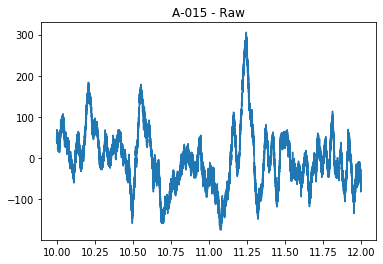

In [227]:
selected_idxs = np.where((t >=10) & (t < 12))[0]  # 2 seconds segment
plt.plot(t[selected_idxs], v[selected_idxs])
plt.title(f'{channel_name} - Raw')
plt.show()

## Effect of filtering

### Notch filter

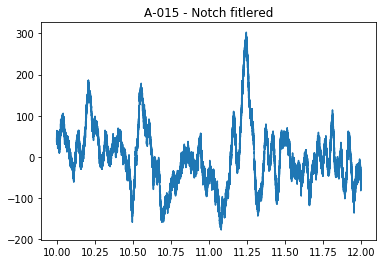

In [248]:
def apply_notch(data, f_sampling, f_notch=60, bandwidth=10):
    """Implements a notch filter (e.g., for 50 or 60 Hz) on vector `data`.

    fSample = sample rate of data (input Hz or Samples/sec)
    fNotch = filter notch frequency (input Hz)
    Bandwidth = notch 3-dB bandwidth (input Hz).  A bandwidth of 10 Hz is
    recommended for 50 or 60 Hz notch filters; narrower bandwidths lead to
    poor time-domain properties with an extended ringing response to
    transient disturbances.

    Example:  If neural data was sampled at 30 kSamples/sec
    and you wish to implement a 60 Hz notch filter:

    out = notch_filter(input, 30000, 60, 10);
    """
    tstep = 1.0 / f_sampling
    Fc = f_notch * tstep

    L = len(data)

    # Calculate IIR filter parameters
    d = math.exp(-2.0*math.pi*(bandwidth/2.0)*tstep)
    b = (1.0 + d*d) * math.cos(2.0*math.pi*Fc)
    a0 = 1.0
    a1 = -b
    a2 = d*d
    a = (1.0 + d*d)/2.0
    b0 = 1.0
    b1 = -2.0 * math.cos(2.0*math.pi*Fc)
    b2 = 1.0

    out = np.zeros(len(data))
    out[0] = data[0]
    out[1] = data[1]
    # (If filtering a continuous data stream, change out[0:1] to the
    #  previous final two values of out.)

    # Run filter
    for i in range(2,L):
        out[i] = (a*b2*data[i-2] + a*b1*data[i-1] + a*b0*data[i] - a2*out[i-2] - a1*out[i-1])/a0

    return out

notch_filtered_v = apply_notch(v, f_sampling=f_sampling)
plt.plot(t[selected_idxs], notch_filtered_v[selected_idxs])
plt.title(f'{channel_name} - Notch fitlered')
plt.show()

### Bandpass filter

Let's apply a bandpass filter to the signal and then re-plot

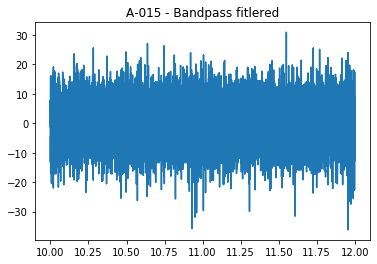

In [268]:
def apply_bandpass(data, f_sampling, f_low, f_high):
    wl = f_low / (f_sampling / 2.)
    wh = f_high / (f_sampling / 2.)
    wn = [wl, wh]

    # Designs a 2nd-order Elliptic band-pass filter which passes
    # frequencies between 0.03 and 0.6, an with 0.1 dB of ripple
    # in the passband, and 40 dB of attenuation in the stopband.
    b, a = ellip(2, 0.1, 40, wn, 'bandpass', analog=False)
    # To match Matlab output, we change default padlen from
    # 3*(max(len(a), len(b))) to 3*(max(len(a), len(b)) - 1)
    return filtfilt(b, a, data, padlen=3 * (max(len(a), len(b)) - 1))

bandpass_filtered_v = apply_bandpass(notch_filtered_v, f_sampling=f_sampling, f_low=300, f_high=6000)
bandpass_filtered_v = bandpass_filtered_v - np.nanmean(bandpass_filtered_v)
plt.plot(t[selected_idxs], bandpass_filtered_v[selected_idxs])
plt.title(f'{channel_name} - Bandpass fitlered')
plt.show()

## Looking at spikes within this time frame

 Let's apply threshold detection

In [303]:
noiseLevel = -4.5 * np.median(np.abs(bandpass_filtered_v)) / 0.6745
outside = np.array(bandpass_filtered_v) < noiseLevel  # Spits a logical array
outside = outside.astype(int)  # Convert logical array to int array for diff to work

cross = np.concatenate(([outside[0]], np.diff(outside, n=1) > 0))

idxs = np.nonzero(cross)[0]
spike_times = t[idxs]

print(spike_times, len(spike_times))

[-8.4725000e-01  1.7125000e-01  6.8915000e-01 ...  2.4892695e+02
  2.4901990e+02  2.4902000e+02] 1309


In [304]:
# Let's pick 20 random trials to plot spike waveforms for
selected_spike_times = np.random.choice(spike_times, 20, replace=False)
selected_spike_times

array([170.57015,  44.83595, 247.58745, 117.05365, 246.50685,  75.13285,
       240.26955,  29.72475, 151.7048 ,  82.22175, 162.5898 ,  74.7496 ,
        33.10705, 241.7214 ,  37.4628 , 102.05325, 246.45365,  19.3008 ,
        43.6582 ,  81.46485])

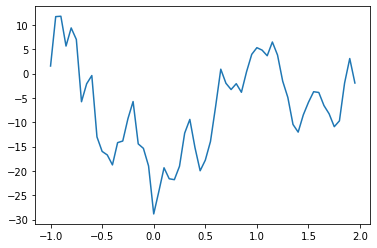

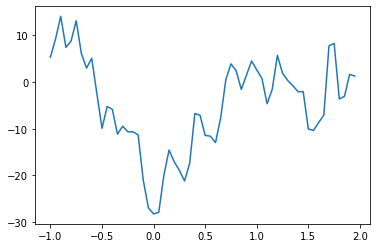

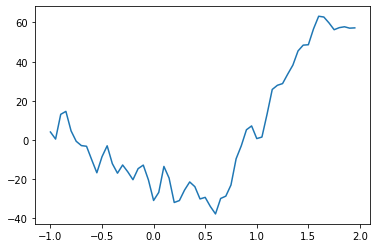

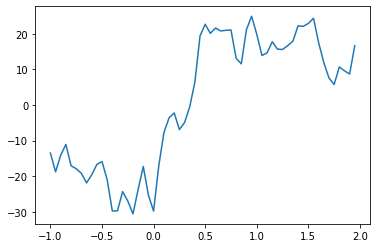

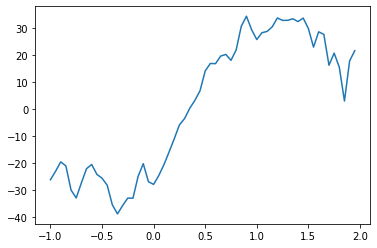

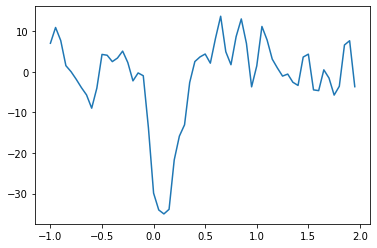

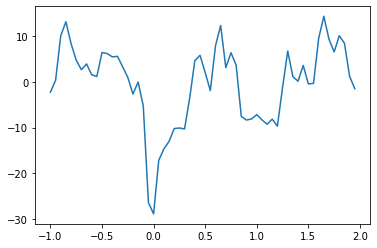

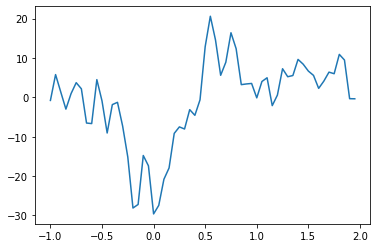

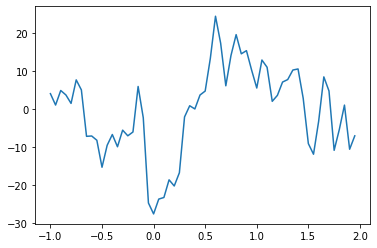

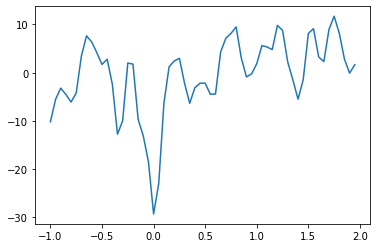

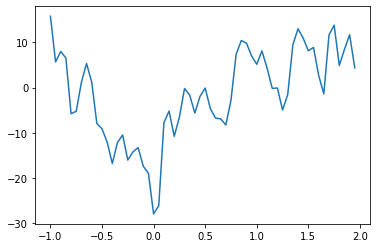

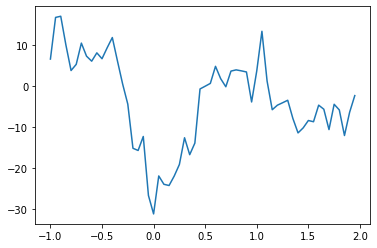

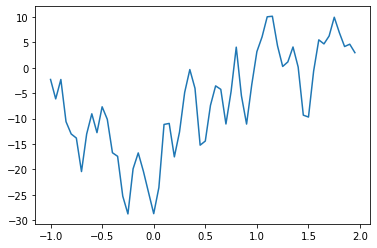

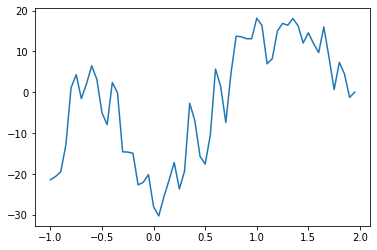

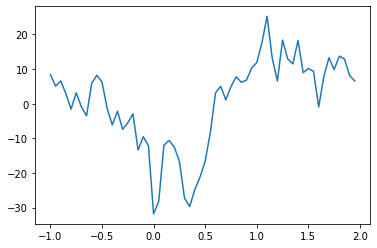

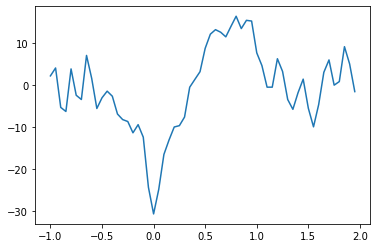

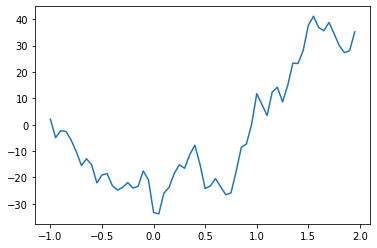

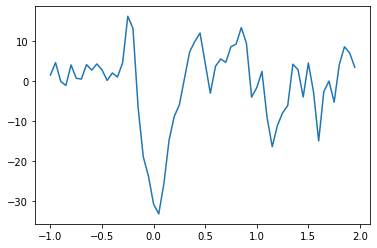

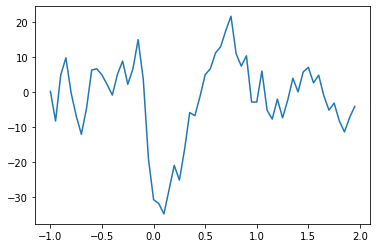

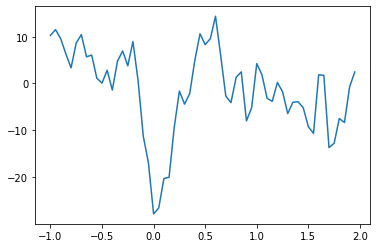

In [306]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
#     return array[idx]
    return idx

x_axis = np.linspace(-1, 2, 3001)
for spk_time in selected_spike_times:
    start_idx = find_nearest(t, spk_time - 0.001)
    stop_idx = find_nearest(t, spk_time + 0.002)
    
    x_axis = (t[start_idx:stop_idx] - spk_time) * 1000
    plt.plot(x_axis, bandpass_filtered_v[start_idx:stop_idx])
    plt.show()